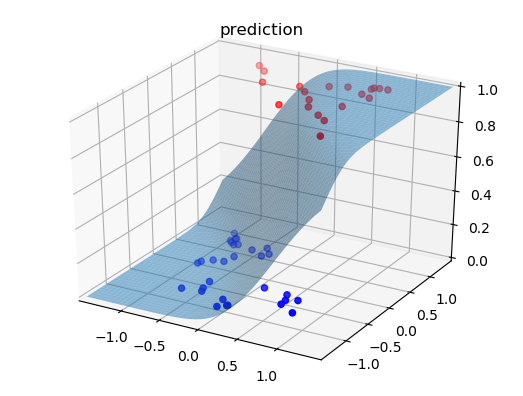

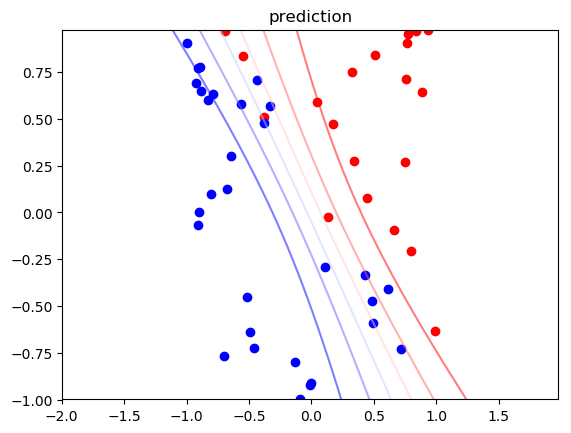

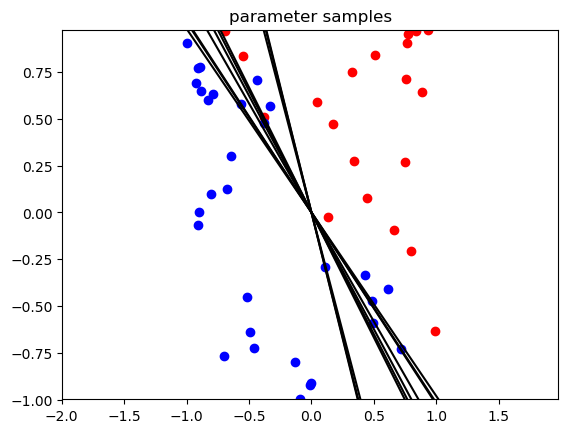

In [3]:
#####################################
## Bayesian logistic regression demo

using PyPlot, PyCall
using Distributions
push!(LOAD_PATH, ".")
import LogisticRegression

"""
Visualize prediction via surface (only for 2D inputs.)
"""
function visualize_surface(mu, rho, X, Y, text)
    N = 100
    R = 100
    xmin = minimum(X[1,:])
    xmax = maximum(X[1,:])
    ymin = minimum(X[2,:])
    ymax = maximum(X[2,:])
    lx = xmax - xmin
    ly = ymax - ymin
    xmin = xmin - 0.25 * lx
    xmax = xmax + 0.25 * lx
    ymin = ymin - 0.25 * ly
    ymax = ymax + 0.25 * ly
    
    x1 = linspace(xmin,xmax,R)
    x2 = linspace(ymin,ymax,R)
    x1grid = repmat(x1, 1, R)
    x2grid = repmat(x2', R, 1)
    val = [x1grid[:] x2grid[:]]'

    z_list = []
    sigma = log.(1 + exp.(rho))
    for n in 1 : N
        W = rand(MvNormal(mu, diagm(sigma.^2)))
        z_tmp = [LogisticRegression.sigmoid(W'*val[:,i]) for i in 1 : size(val, 2)]
        push!(z_list, z_tmp)
    end
    z = mean(z_list)
    zgrid = reshape(z, R, R)

    # 3D plot
    figure("surface")
    clf()
    plot_surface(x1grid, x2grid, zgrid, alpha=0.5)
    scatter3D(X[1,Y.==1], X[2,Y.==1], Y[Y.==1]+0.01, c="r", depthshade=true)
    scatter3D(X[1,Y.==0], X[2,Y.==0], Y[Y.==0], c="b", depthshade=true)
    xlim([xmin, xmax])
    ylim([ymin, ymax])
    zlim([0, 1])
    title(text)
end

"""
Visualize prediction via contour (only for 2D inputs.)
"""
function visualize_contour(mu, rho, X, Y)
    N = 100
    R = 100
    xmin = 2*minimum(X[1,:])
    xmax = 2*maximum(X[1,:])
    ymin = minimum(X[2,:])
    ymax = maximum(X[2,:])

    x1 = linspace(xmin,xmax,R)
    x2 = linspace(ymin,ymax,R)
    x1grid = repmat(x1, 1, R)
    x2grid = repmat(x2', R, 1)
    val = [x1grid[:] x2grid[:]]'

    z_list = []
    W_list = []
    sigma = log.(1 + exp.(rho))
    for n in 1 : N
        W = rand(MvNormal(mu, diagm(sigma.^2)))
        z_tmp = [LogisticRegression.sigmoid(W'*val[:,i]) for i in 1 : size(val, 2)]
        push!(W_list, W)
        push!(z_list, z_tmp)
    end
    z = mean(z_list)
    zgrid = reshape(z, R, R)

    # precition
    figure("contour")
    clf()
    contour(x1grid, x2grid, zgrid, alpha=0.5, cmap=get_cmap("bwr"))
    scatter(X[1,Y.==1], X[2,Y.==1], c="r")
    scatter(X[1,Y.==0], X[2,Y.==0], c="b")
    xlim([xmin, xmax])
    ylim([ymin, ymax])
    title("prediction")

    # parameter samples
    figure("samples")
    clf()
    for n in 1 : 10
        draw_line(W_list[n], xmin, xmax)
    end
    scatter(X[1,Y.==1]', X[2,Y.==1]', c="r")
    scatter(X[1,Y.==0]', X[2,Y.==0]', c="b")
    xlim([xmin, xmax])
    ylim([ymin, ymax])
    title("parameter samples")
end

function draw_line(W, xmin, xmax)
    y1 = - xmin*W[1]/W[2]
    y2 = - xmax*W[1]/W[2]
    plot([xmin, xmax], [y1, y2], c="k")
end


########################
# create model

M = 2 # input dimension
Sigma_w = 100.0 * eye(M) # prior on W

########################
# create toy-data using prior model

N = 50 # num of data points
X = 2 * rand(M, N) - 1.0 # input values

# sample observation Y
Y, _ = LogisticRegression.sample_data(X, Sigma_w)

########################
# inference
alpha = 1.0e-4 # learning rate
max_iter = 100000 # VI maximum iterations 

# learn variational parameters (mu & rho)
mu, rho = LogisticRegression.VI(Y, X, M, Sigma_w, alpha, max_iter)

########################
# visualize (only for M=2)
visualize_surface(mu, rho, X, Y, "prediction")
visualize_contour(mu, rho, X, Y)
show()